In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
import itertools  

pd.options.mode.chained_assignment = None  # default='warn'

## Data Preparation

In [ ]:
csv_path = "D:\TA\CSV\tail_686_1"
csv_list = []

for root, dirs, files in os.walk(csv_path):
    for file in files:
        csv_list.append(os.path.join(root, file))

In [ ]:
# List semua df nya
csv_list

## Data Loading & Preprocessing

### 1. FDM Data

In [ ]:
# For FDM Data
def preprocess_fdm(df):
    df_temp = df.dropna()
    df_temp = df_temp.reset_index(drop=True)
    return df_temp

In [ ]:
# Read all FDM data
all_fdm = []
for fdm_csv in csv_list:
    df_fdm = pd.read_csv(fdm_csv)
    df_fdm = preprocess_fdm(df_fdm)
    all_fdm.append(df_fdm)

In [ ]:
df_fdm.plot(kind='line', y='flap_te_pos')
plt.show()

### 2. Airport & Runways Data

In [ ]:
# Read airports & runways
path_airports = "airports (radians).xlsx"
path_runways = "runways (radians).xlsx"

df_airports = pd.read_excel(path_airports, index_col=0)  
df_runways = pd.read_excel(path_runways, index_col=0)

In [ ]:
# Drop null value
df_airports = df_airports.dropna(subset=["iata_code","latitude_rad","longitude_rad"])
df_runways = df_runways.dropna(subset=["iata_code","le_latitude_rad","le_longitude_rad","he_latitude_rad","he_longitude_rad"]) 

# Reset Index
df_airports = df_airports.reset_index(drop=True)
df_runways = df_runways.reset_index(drop=True)

### 3. Data Preview

In [ ]:
display(all_fdm[0].head())
display(df_airports.head())
display(df_runways.head())

### Get `wow` Info
Condition
- Arrival: `wow = 0`, before the first `wow = 1`
- Departure: `wow = 0`, after the last `wow = 1`

In [ ]:
def getWowInfo(fdm):
    takeoff_idx = fdm[fdm['wow'] == 1].index[0]
    departure = fdm[fdm['wow'] == 0][:takeoff_idx]
    arrival = fdm[fdm['wow'] == 0][takeoff_idx:]
    return (departure, arrival)

### Find Airport from FDM

In [ ]:
def find_airport(df_fdm, airports):
    departure, arrival = getWowInfo(df_fdm)
    
    # Train Airport Data using KNN
    X_train = pd.DataFrame(airports, columns=['latitude_rad','longitude_rad'])
    y_train = pd.DataFrame(airports, columns=['iata_code'])
    knn = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto', metric='euclidean')
    knn.fit(X_train, y_train.values.ravel())
    
    # Predict Airports for Departure and Arrival
    # Departure (return first result only)
    X_departure = departure[['lat_rad', 'lon_rad']]
    y_departure = knn.predict(X_departure)
    dep_airport = y_departure[0]

    # Arrival (return first result only)
    X_arrival = arrival[['lat_rad', 'lon_rad']]
    y_arrival = knn.predict(X_arrival)
    arr_airport = y_arrival[0]
    
    return dep_airport, arr_airport

### Find Runway from FDM

In [ ]:
all_fdm[0]['psi_rad']

In [ ]:
df_runways.loc[df_runways['iata_code'] == 'DTW']

In [ ]:
def find_runway(df_fdm, runways):
    departure, arrival = getWowInfo(df_fdm)
    
    # Train Runway Data using KNN
    X_train_runway = pd.DataFrame(runways, columns=['le_latitude_rad','le_longitude_rad'])
    y_train_runway = pd.DataFrame(runways, columns=['he_ident', 'le_ident', 'iata_code'])
    knn_runway = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto', metric='euclidean')
    knn_runway.fit(X_train_runway, y_train_runway)
    
    # Predict runway
    X_departure = departure[['lat_rad', 'lon_rad']]
    X_arrival = arrival[['lat_rad', 'lon_rad']]
    
    arr_runway = knn_runway.predict(X_arrival)[0]
    dep_runway = knn_runway.predict(X_departure)[0]
    
    return dep_runway, arr_runway

### Create Dataframe

In [46]:
all_fdm_info = []
for fdm_csv, df_fdm in zip(csv_list, all_fdm):
    dep, arr = find_airport(df_fdm, df_airports)
    dep_run, arr_run = find_runway(df_fdm, df_runways)
    row = [fdm_csv, dep, arr]
    row.extend(dep_run)
    row.extend(arr_run)    
    print(row)
    all_fdm_info.append(row)
    
col_names = ['filepath', 'dep', 'arr', 'dep_he_ident', 'dep_le_ident', 'dep_iata', 'arr_he_ident', 'arr_le_ident', 'arr_iata']
df_fdm_info = pd.DataFrame(all_fdm_info, columns = col_names)
df_fdm_info.to_csv('fdm_info.csv')
display(df_fdm_info)

['csv/DTW_21R_03L_BTV_33_15_686200104131828.csv', 'DTW', 'BTV', '21R', '03L', 'DTW', '33', '15', 'BTV']
['csv/DTW_27R_09L_AZO_23_05_686200104140630.csv', 'DTW', 'AZO', '27R', '09L', 'DTW', '23', '05', 'AZO']
['csv/AZO_27_09_DTW_27R_09L_686200104140758.csv', 'AZO', 'DTW', '27', '09', 'AZO', '27R', '09L', 'DTW']
['csv/DTW_27R_09L_LEX_22_04_686200104120802.csv', 'DTW', 'LEX', '27R', '09L', 'DTW', '22', '04', 'LEX']
['csv/TVC_28_10_DTW_22R_04L_686200104131618.csv', 'TVC', 'DTW', '28', '10', 'TVC', '22R', '04L', 'DTW']
['csv/BTV_19_01_DTW_21R_03L_686200104140345.csv', 'BTV', 'DTW', '19', '01', 'BTV', '21R', '03L', 'DTW']


,filepath,dep,arr,dep_he_ident,dep_le_ident,dep_iata,arr_he_ident,arr_le_ident,arr_iata
0,csv/DTW_21R_03L_BTV_33_15_686200104131828.csv,DTW,BTV,21R,03L,DTW,33,15,BTV
1,csv/DTW_27R_09L_AZO_23_05_686200104140630.csv,DTW,AZO,27R,09L,DTW,23,05,AZO
2,csv/AZO_27_09_DTW_27R_09L_686200104140758.csv,AZO,DTW,27,09,AZO,27R,09L,DTW
3,csv/DTW_27R_09L_LEX_22_04_686200104120802.csv,DTW,LEX,27R,09L,DTW,22,04,LEX
4,csv/TVC_28_10_DTW_22R_04L_686200104131618.csv,TVC,DTW,28,10,TVC,22R,04L,DTW
5,csv/BTV_19_01_DTW_21R_03L_686200104140345.csv,BTV,DTW,19,01,BTV,21R,03L,DTW


In [45]:
df_fdm_info['new_name'] = df_fdm_info.apply(lambda row: os.path.split(row.filepath)[0] + '/' + row.dep_iata + '_' + row.dep_he_ident + '_' + row.dep_le_ident + '_' + row.arr_iata + '_' + row.arr_he_ident + '_' + row.arr_le_ident + '_' + os.path.split(row.filepath)[1], axis=1)
df_fdm_info

,filepath,dep,arr,dep_he_ident,dep_le_ident,dep_iata,arr_he_ident,arr_le_ident,arr_iata,new_name,unstable_approach
0,csv/DTW_21R_03L_BTV_33_15_686200104131828.csv,DTW,BTV,21R,03L,DTW,33,15,BTV,csv/DTW_21R_03L_BTV_33_15_DTW_21R_03L_BTV_33_1...,unstable
1,csv/DTW_27R_09L_AZO_23_05_686200104140630.csv,DTW,AZO,27R,09L,DTW,23,05,AZO,csv/DTW_27R_09L_AZO_23_05_DTW_27R_09L_AZO_23_0...,unstable
2,csv/AZO_27_09_DTW_27R_09L_686200104140758.csv,AZO,DTW,27,09,AZO,27R,09L,DTW,csv/AZO_27_09_DTW_27R_09L_AZO_27_09_DTW_27R_09...,unstable
3,csv/DTW_27R_09L_LEX_22_04_686200104120802.csv,DTW,LEX,27R,09L,DTW,22,04,LEX,csv/DTW_27R_09L_LEX_22_04_DTW_27R_09L_LEX_22_0...,unstable
4,csv/TVC_28_10_DTW_22R_04L_686200104131618.csv,TVC,DTW,28,10,TVC,22R,04L,DTW,csv/TVC_28_10_DTW_22R_04L_TVC_28_10_DTW_22R_04...,unstable
5,csv/BTV_19_01_DTW_21R_03L_686200104140345.csv,BTV,DTW,19,01,BTV,21R,03L,DTW,csv/BTV_19_01_DTW_21R_03L_BTV_19_01_DTW_21R_03...,unstable


### Renaming file (Kalau udah rename gak perlu di run lagi)

In [33]:
for index, row in df_fdm_info.iterrows():
    old = row['filepath']
    new = row['new_name']
#     os.rename(old, new)
    print(row['filepath'], '->', row['new_name'])

csv/DTW_21R_03L_BTV_33_15_686200104131828.csv -> csv/DTW_21R_03L_BTV_33_15_DTW_21R_03L_BTV_33_15_686200104131828.csv
csv/DTW_27R_09L_AZO_23_05_686200104140630.csv -> csv/DTW_27R_09L_AZO_23_05_DTW_27R_09L_AZO_23_05_686200104140630.csv
csv/AZO_27_09_DTW_27R_09L_686200104140758.csv -> csv/AZO_27_09_DTW_27R_09L_AZO_27_09_DTW_27R_09L_686200104140758.csv
csv/DTW_27R_09L_LEX_22_04_686200104120802.csv -> csv/DTW_27R_09L_LEX_22_04_DTW_27R_09L_LEX_22_04_686200104120802.csv
csv/TVC_28_10_DTW_22R_04L_686200104131618.csv -> csv/TVC_28_10_DTW_22R_04L_TVC_28_10_DTW_22R_04L_686200104131618.csv
csv/BTV_19_01_DTW_21R_03L_686200104140345.csv -> csv/BTV_19_01_DTW_21R_03L_BTV_19_01_DTW_21R_03L_686200104140345.csv


## Detect Unstable Approach

In [40]:
def get_cruising_df(df_fdm):
    idx_max = np.where(df_fdm['hbaro_m'].eq(max(df_fdm['hbaro_m'])), df_fdm.index, 0).max()+1
    df_fdm_max = df_fdm.loc[idx_max:]
    df_fdm_max = df_fdm_max[df_fdm_max['hbaro_m'] <= 3000]
    df_fdm_max = df_fdm_max[df_fdm_max['hbaro_m'] >= 1000]
    return df_fdm_max

def unstable_approach(df_fdm):
    #Read excel and convert to dictionary
    path_param = "Table Parameter.xlsx"
    df_params = pd.read_excel(path_param, index_col=0)
    params = df_params[['Param','Kondisi']].to_dict()

    #Slice df_fdm to 3000-1000
    df_fdm = get_cruising_df(df_fdm)
    
    #Create unstable approach function using string and exec
    param_list = df_params.values.tolist()
    
    # Start string execution
    complete_cond = '"unstable" if ('
    for param in param_list[:-1]:
        cond_str = '(df_fdm.' + param[0] + param[1] + str(param[2]) + ').any or \n'
        complete_cond = complete_cond + cond_str

    cond_str_lst = '(df_fdm.' + param_list[-1][0] + param_list[-1][1] + str(param_list[-1][2]) + ').any)'

    # For displaying condition
    complete_cond = complete_cond + cond_str_lst
    
    # For executing with action
    final_cond = complete_cond + 'else "stable"'
    
    # Show plot
    print(my_exec(final_cond))
    df_fdm.plot(kind='line', y='hbaro_m')

    return(my_exec(final_cond))

def my_exec(code):
    exec('global i; i = %s' % code)
    global i
    return i

unstable
unstable
unstable
unstable
unstable
unstable


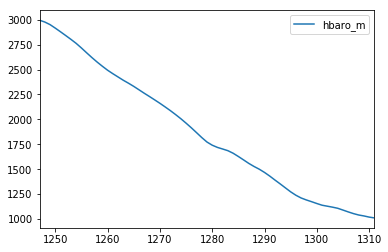

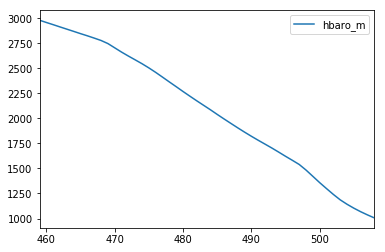

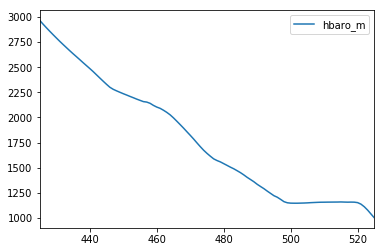

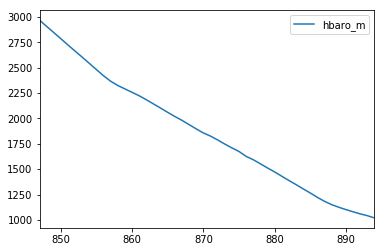

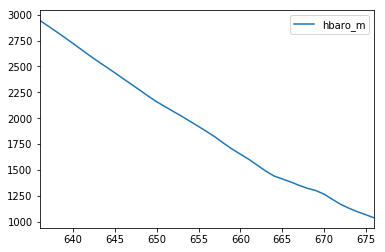

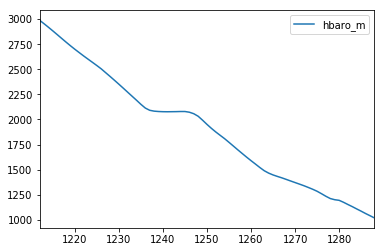

In [41]:
# Compute unstable
result_unstable = []
for df_fdm in all_fdm:
    result_unstable.append(unstable_approach(df_fdm))

In [42]:
# Add to df_fdm_info
df_fdm_info['unstable_approach'] = result_unstable
df_fdm_info

,filepath,dep,arr,dep_he_ident,dep_le_ident,dep_iata,arr_he_ident,arr_le_ident,arr_iata,new_name,unstable_approach
0,csv/DTW_21R_03L_BTV_33_15_686200104131828.csv,DTW,BTV,21R,03L,DTW,33,15,BTV,csv/DTW_21R_03L_BTV_33_15_DTW_21R_03L_BTV_33_1...,unstable
1,csv/DTW_27R_09L_AZO_23_05_686200104140630.csv,DTW,AZO,27R,09L,DTW,23,05,AZO,csv/DTW_27R_09L_AZO_23_05_DTW_27R_09L_AZO_23_0...,unstable
2,csv/AZO_27_09_DTW_27R_09L_686200104140758.csv,AZO,DTW,27,09,AZO,27R,09L,DTW,csv/AZO_27_09_DTW_27R_09L_AZO_27_09_DTW_27R_09...,unstable
3,csv/DTW_27R_09L_LEX_22_04_686200104120802.csv,DTW,LEX,27R,09L,DTW,22,04,LEX,csv/DTW_27R_09L_LEX_22_04_DTW_27R_09L_LEX_22_0...,unstable
4,csv/TVC_28_10_DTW_22R_04L_686200104131618.csv,TVC,DTW,28,10,TVC,22R,04L,DTW,csv/TVC_28_10_DTW_22R_04L_TVC_28_10_DTW_22R_04...,unstable
5,csv/BTV_19_01_DTW_21R_03L_686200104140345.csv,BTV,DTW,19,01,BTV,21R,03L,DTW,csv/BTV_19_01_DTW_21R_03L_BTV_19_01_DTW_21R_03...,unstable
